| Name                 | ID       |
|----------------------|----------|
| Jaime Simoes         | 20230522 |
| Maximilian Laechelin | 20230979 |
| Ilyass Jannah        | 20230598 |


In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from dateutil import parser
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from minisom import MiniSom
from matplotlib import cm
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors as mpl_colors, colorbar
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth, AgglomerativeClustering
from sklearn.base import clone
from scipy.cluster.hierarchy import dendrogram, linkage as scipy_linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

sns.set()

## Loading Processed data 

In [63]:
data = pd.read_csv('cleaned_data.csv')

In [64]:
data.head()

,Gender,Income,DaysWithoutFrequency,LifetimeValue,UseByTime,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,NumberOfFrequencies,AttendedClasses,NumberOfReferences,Dropout,EnrolledTime,DaysSinceLastVisit,LazinessIndex
0,0,5500.0,1,89.35,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,7,0,0,58,1,0.681529
1,0,2630.0,60,479.20,0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,1,0,1,398,1568,0.942595
2,1,1980.0,7,37.60,0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0,0,1,30,889,0.800200
3,1,0.0,22,155.40,0,0.0,0.0,1.0,0.0,0.0,0.0,20.0,2,0,1,160,283,0.830700
4,1,4320.0,210,373.20,0,0.0,1.0,0.0,0.0,0.0,0.0,41.0,0,0,1,778,721,1.000000


In [65]:
data.columns

Index(['Gender', 'Income', 'DaysWithoutFrequency', 'LifetimeValue',
       'UseByTime', 'WaterActivities', 'FitnessActivities', 'TeamActivities',
       'RacketActivities', 'CombatActivities', 'SpecialActivities',
       'NumberOfFrequencies', 'AttendedClasses', 'NumberOfReferences',
       'Dropout', 'EnrolledTime', 'DaysSinceLastVisit', 'LazinessIndex'],
      dtype='object')

## Scaling the data

### Standard Scaler 

In [66]:
scaler = StandardScaler()
data_std = scaler.fit_transform(data)
data_std = pd.DataFrame(data_std, columns=data.columns)

### MinMax Scaler 

In [67]:
scaler = MinMaxScaler()
data_mm = scaler.fit_transform(data)
data_mm = pd.DataFrame(data_mm, columns=data.columns)

## Feature Selection
We chose to manually select the features because by models it goes for the best defined clusters but with features that don't allow us to make valuable interpretations for the matter in hand. A more trial and error approach is in place. These lists can then be merged to find relations between the corresponding topics.

In [68]:
metric_features = ['Income', 'DaysWithoutFrequency', 'NumberOfFrequencies', 'LifetimeValue',
                    'AttendedClasses', 'NumberOfReferences', 'EnrolledTime', 'DaysSinceLastVisit', 'LazinessIndex']

In [69]:
demographic_features = ["Gender","Income","LifetimeValue"]

In [70]:
behaviou_features = ["DaysWithoutFrequency","UseByTime","NumberOfFrequencies","AttendedClasses","NumberOfReferences",
             "DaysSinceLastVisit","LazinessIndex"]

In [71]:
activities_features = ["WaterActivities","FitnessActivities","TeamActivities","RacketActivities","CombatActivities","SpecialActivities"]

In [72]:
subscription_features = ["EnrolledTime","Dropout"]

### R^2 function 

In [73]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

# Simple K-means

### Elbow Method 

C:\DOCUMENTOS\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\DOCUMENTOS\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\DOCUMENTOS\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\DOCUMENTOS\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

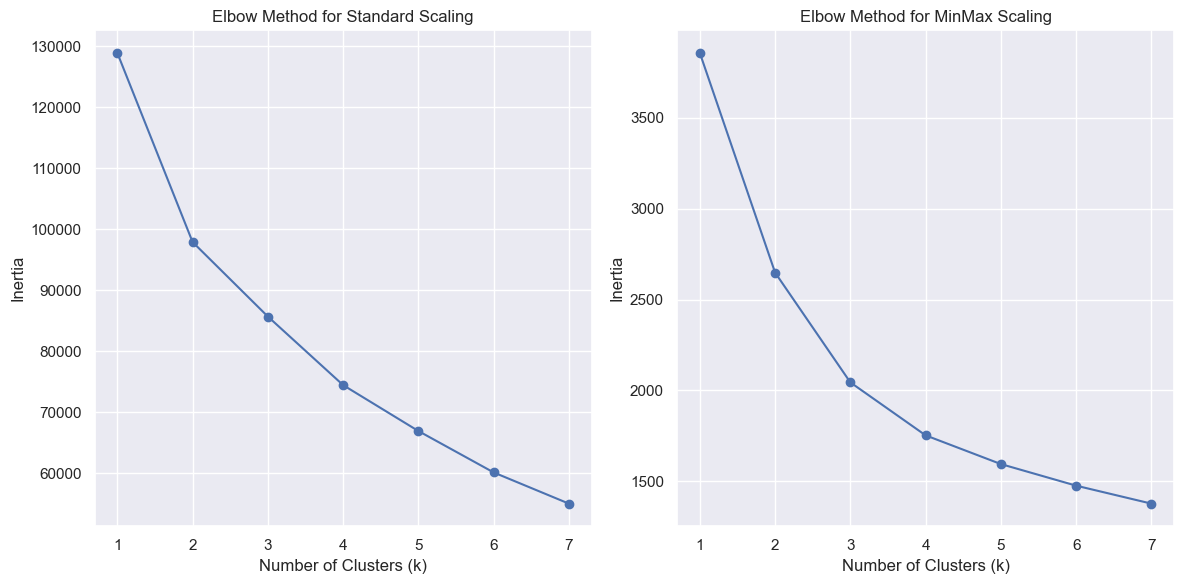

In [74]:
def elbow_method_and_plot(data, ax, title):
    inertias = []
    
    for k in range(1, 8):
        kmeans = KMeans(n_clusters=k, random_state=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    ax.plot(range(1, 8), inertias, marker='o')
    ax.set_title(title)
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('Inertia')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

elbow_method_and_plot(data_std[metric_features], axs[0], 'Elbow Method for Standard Scaling')
elbow_method_and_plot(data_mm[metric_features], axs[1], 'Elbow Method for MinMax Scaling')

plt.tight_layout()
plt.show()

### Silhouette Score 

C:\DOCUMENTOS\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\DOCUMENTOS\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\DOCUMENTOS\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\DOCUMENTOS\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

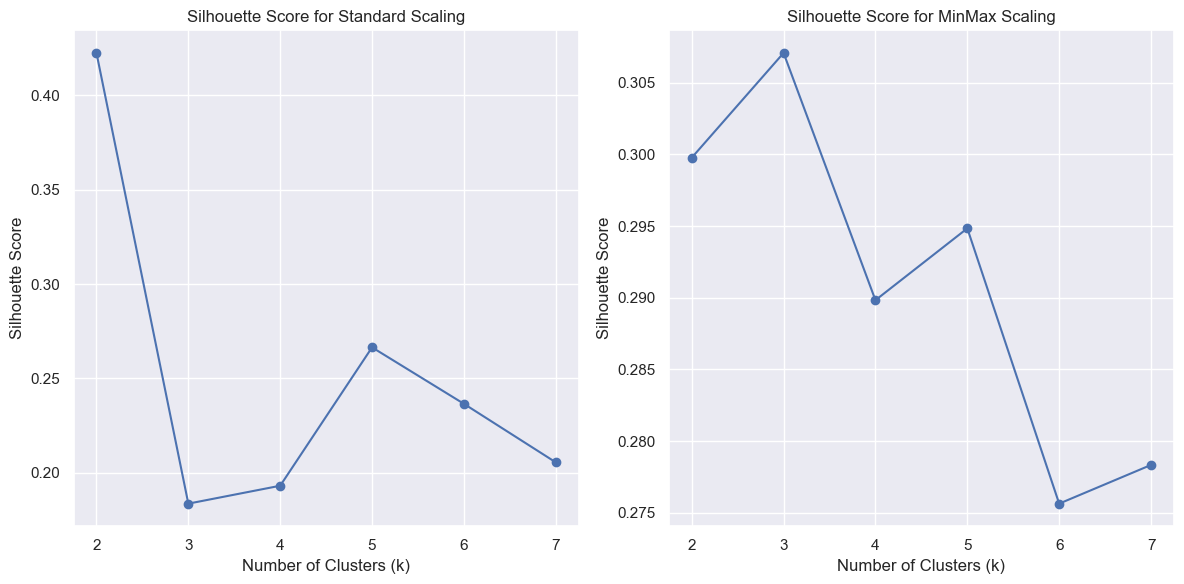

In [75]:
def silhouette_score_and_plot(data, ax, title):
    silhouette_scores = []
    
    for k in range(2, 8):
        kmeans = KMeans(n_clusters=k, random_state=10)
        kmeans.fit(data)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    ax.plot(range(2, 8), silhouette_scores, marker='o')
    ax.set_title(title)
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('Silhouette Score')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

silhouette_score_and_plot(data_std[metric_features], axs[0], 'Silhouette Score for Standard Scaling')
silhouette_score_and_plot(data_mm[metric_features], axs[1], 'Silhouette Score for MinMax Scaling')

plt.tight_layout()
plt.show()

### Finding the Clusters

In [76]:
def clustering(data, metric_features, n_clusters):
    
    # Use only metric features for clustering
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=10)
    clusters = kmeans.fit_predict(data[metric_features])

    data_copy = data.copy() 
    data_copy['KMeanCluster'] = clusters

    # Calculate mean of features per cluster
    cluster_means = data_copy.groupby('KMeanCluster').mean().T
    
    # Get R^2
    sst = get_ss(data[metric_features])  
    ssw_labels = data_copy.groupby(by='KMeanCluster').apply(lambda x: get_ss(x[metric_features]))
    ssb = sst - np.sum(ssw_labels)  
    r2 = ssb / sst
 
    styled_cluster_means = cluster_means.style.format(precision=2).background_gradient(axis=1)

    return data_copy, styled_cluster_means, r2

In [77]:
cluster_std, styled_cluster_std, r2_std = clustering(data_std, metric_features, n_clusters=3)
cluster_mm, styled_cluster_mm, r2_mm = clustering(data_mm, metric_features, n_clusters=3)

In [78]:
print(f"R^2 for Standardized Data: {r2_std:.4f}")
print(f"R^2 for Min-Max Scaled Data: {r2_mm:.4f}")

R^2 for Standardized Data: 0.3355
R^2 for Min-Max Scaled Data: 0.4698


In [79]:
print(cluster_std['KMeanCluster'].value_counts())
styled_cluster_std

KMeanCluster
0    7201
2    5196
1    1929
Name: count, dtype: int64


KMeanCluster,0,1,2
Gender,-0.02,0.17,-0.04
Income,0.04,-0.16,0.01
DaysWithoutFrequency,-0.46,-0.37,0.78
LifetimeValue,-0.30,2.00,-0.33
UseByTime,-0.06,0.12,0.03
WaterActivities,-0.07,0.73,-0.17
FitnessActivities,0.10,-0.48,0.04
TeamActivities,-0.04,0.14,0.01
RacketActivities,-0.07,-0.01,0.10
CombatActivities,-0.01,-0.09,0.05


In [80]:
print(cluster_mm['KMeanCluster'].value_counts())
styled_cluster_mm

KMeanCluster
2    6206
0    5838
1    2282
Name: count, dtype: int64


KMeanCluster,0,1,2
Gender,0.38,0.49,0.39
Income,0.25,0.23,0.24
DaysWithoutFrequency,0.10,0.11,0.24
LifetimeValue,0.08,0.36,0.08
UseByTime,0.03,0.10,0.04
WaterActivities,0.29,0.54,0.20
FitnessActivities,0.59,0.43,0.63
TeamActivities,0.05,0.09,0.04
RacketActivities,0.00,0.01,0.05
CombatActivities,0.11,0.10,0.11


# Self Organizing Maps

In [81]:
def plot_som_hexagons(som,
                      matrix,
                      cmap=cm.Blues,
                      figsize=(6.5,6.5),
                      annotate=True,
                      title="SOM Matrix",
                      cbar_label="Color Scale"
                ):

    xx, yy = som.get_euclidean_coordinates()

    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(111)

    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)

    colornorm = mpl_colors.Normalize(vmin=np.min(matrix), 
                                     vmax=np.max(matrix))

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.95 / np.sqrt(3),
                                 facecolor=cmap(colornorm(matrix[i, j])), 
                                 alpha=1)
            ax.add_patch(hexagon)

            if annotate:
                annot_vals = np.round(matrix[i, j],2)
                if annot_vals > 1:
                    annot_vals = int(annot_vals)
                
                ax.text(xx[(i, j)], wy, annot_vals, 
                        ha='center', va='center', 
                        fontsize=figsize[1], 
                        )

    ax.margins(.05)
    ax.axis("off")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="2%", pad=0)    
    cb1 = colorbar.ColorbarBase(ax_cb, 
                                orientation='vertical', 
                                alpha=1,
                                mappable=cmap_sm
                               )
    cb1.ax.get_yaxis().labelpad = 12
    cb1.ax.set_ylabel(cbar_label, fontsize=14)
    plt.gcf().add_axes(ax_cb)

    return plt

### Hit Map 
Shows the frequency of each Unit in the output map.
We want the smallest quantization error possible. Adjust the parameters.

Quantization Error: 1.5965654322952028


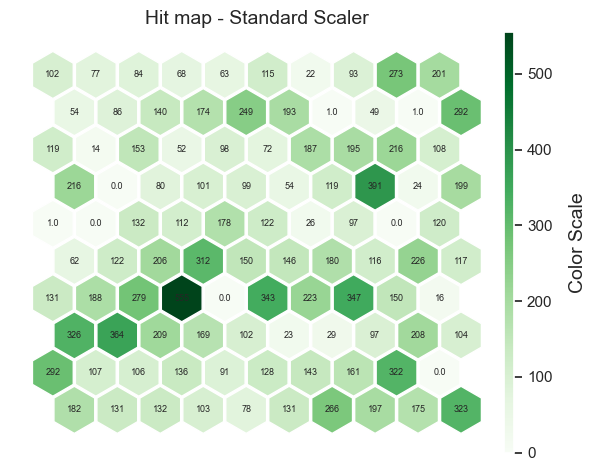

Quantization Error: 0.312218664226867


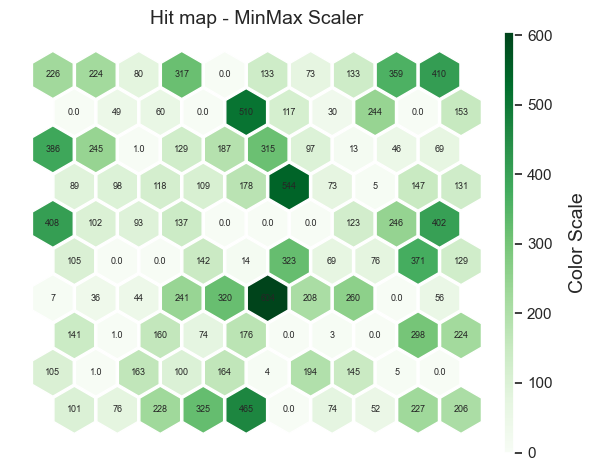

In [82]:
matrix_list = [data_std, data_mm]
titles = ["Hit map - Standard Scaler", "Hit map - MinMax Scaler"]

for matrix, title in zip(matrix_list, titles):
   
    num_columns = matrix.shape[1]
    sm = MiniSom(10,10, 
             num_columns, 
             learning_rate=0.3,    # adjust 
             activation_distance='euclidean',
             topology='hexagonal', 
             neighborhood_function='gaussian', 
             random_seed=10
             )

    sm.train(matrix.values, num_iteration=15000)    # adjust
    quantization_err = sm.quantization_error(matrix.values)
    print("Quantization Error:", quantization_err)
    
    hits_matrix = sm.activation_response(matrix.values)
    fig = plot_som_hexagons(sm, hits_matrix, cmap=cm.Greens, title=title)
    plt.show()

### SOM Matrix
Represents the distances between the neurons.

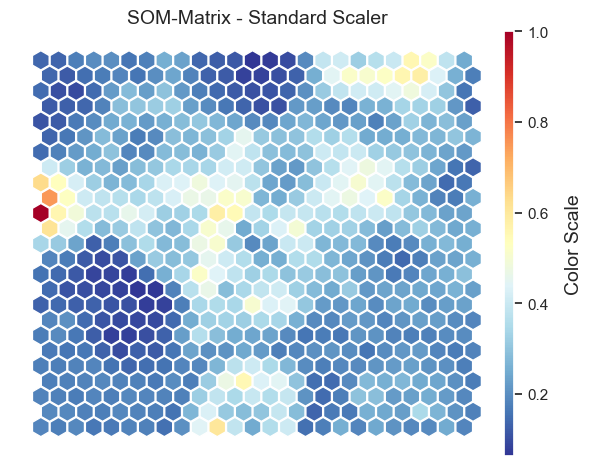

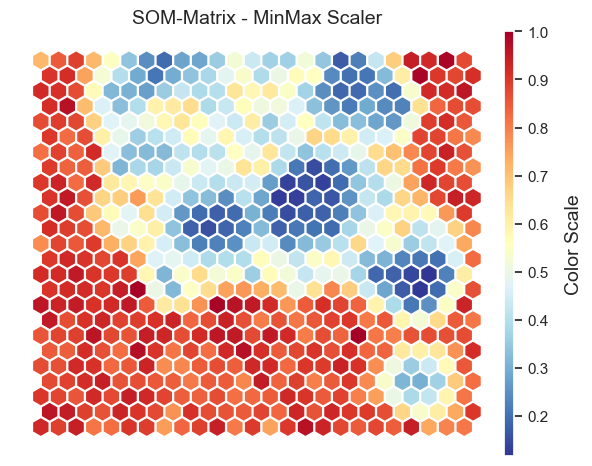

In [83]:
matrix_list = [data_std, data_mm]
titles = ["SOM-Matrix - Standard Scaler", "SOM-Matrix - MinMax Scaler"]

for matrix, title in zip(matrix_list, titles):
    
    sm_instance = MiniSom(25, 25, matrix.shape[1], learning_rate=0.3, 
                          activation_distance='euclidean',
                          topology='hexagonal', 
                          neighborhood_function='gaussian', 
                          random_seed=10)

    sm_instance.train(matrix.values, num_iteration=15000)
    umatrix = sm_instance.distance_map(scaling='mean')

    fig = plot_som_hexagons(sm_instance, umatrix, cmap=cm.RdYlBu_r, title=title, annotate=False)
    plt.show()

### Finding Clusters 

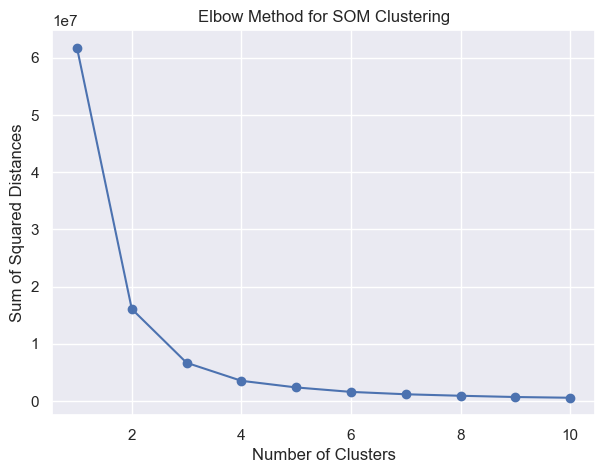

In [84]:
# First perform the elbow method

num_columns = data_std.shape[1]
map_size = (15, 15)
num_iterations = 15000

som = MiniSom(map_size[0], map_size[1], num_columns,
              learning_rate=0.3, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(data_std.values, num_iteration=num_iterations)

# Find the winning neuron for each input pattern
winning_neurons = np.array([som.winner(pattern) for pattern in data_std.values])

# Flatten the coordinates for clustering
flattened_neurons = winning_neurons[:, 0] * som._weights.shape[1] + winning_neurons[:, 1]

distortions = []
max_clusters = 10

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20, random_state=10)
    clusters = kmeans.fit_predict(flattened_neurons.reshape(-1, 1))
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.title('Elbow Method for SOM Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [92]:
def train_som_and_cluster(data, metric_features, num_clusters, map_size=(15, 15), num_iterations=15000):

    
    data_metric = data[metric_features]

    num_columns = data_metric.shape[1]

    som = MiniSom(map_size[0], map_size[1], num_columns,
                  learning_rate=0.3, activation_distance='euclidean',
                  topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

    som.train(data_metric.values, num_iteration=num_iterations)

    # Find winning neuron for each input pattern
    winning_neurons = np.array([som.winner(pattern) for pattern in data_metric.values])

    # Flatten the coordinates for clustering
    flattened_neurons = winning_neurons[:, 0] * som._weights.shape[1] + winning_neurons[:, 1]

    # Make clusters with KMeans on the neurons
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=20, random_state=10)
    clusters = kmeans.fit_predict(flattened_neurons.reshape(-1, 1))

    data_with_clusters = data.copy()
    data_with_clusters['SOMCluster'] = clusters
    
    # Get R^2
    sst = get_ss(data_metric)  # get total sum of squares
    ssw_labels = data_with_clusters.groupby(by='SOMCluster').apply(lambda x: get_ss(x[metric_features]))
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst

    cluster_means = data_with_clusters.groupby('SOMCluster').mean().T
    styled_cluster_means = cluster_means.style.format(precision=2).background_gradient(axis=1)

    return data_with_clusters, styled_cluster_means, r2

data_mm3_with_clusters, styled_cluster_mm3, r2_mm3 = train_som_and_cluster(data_mm, metric_features, num_clusters=3)    # try for 3 and 4 clusters
data_mm4_with_clusters, styled_cluster_mm4, r2_mm4 = train_som_and_cluster(data_mm, metric_features, num_clusters=4)

In [93]:
print(f"R^2 for SOM Clustering with 3 clusters: {r2_mm3:.4f}")
print(f"R^2 for SOM Clustering with 4 clusters: {r2_mm4:.4f}")

R^2 for SOM Clustering with 3 clusters: 0.1788
R^2 for SOM Clustering with 4 clusters: 0.2517


In [94]:
print(data_mm3_with_clusters['SOMCluster'].value_counts())
styled_cluster_mm3            # For MinMax scaler   (The best of scalers)

SOMCluster
2    5705
1    4906
0    3715
Name: count, dtype: int64


SOMCluster,0,1,2
Gender,0.42,0.42,0.37
Income,0.20,0.27,0.25
DaysWithoutFrequency,0.28,0.07,0.16
LifetimeValue,0.22,0.13,0.06
UseByTime,0.07,0.06,0.02
WaterActivities,0.50,0.25,0.18
FitnessActivities,0.35,0.67,0.65
TeamActivities,0.10,0.04,0.03
RacketActivities,0.03,0.01,0.03
CombatActivities,0.09,0.11,0.12


In [95]:
print(data_mm4_with_clusters['SOMCluster'].value_counts())
styled_cluster_mm4

SOMCluster
1    4533
3    3931
2    3516
0    2346
Name: count, dtype: int64


SOMCluster,0,1,2,3
Gender,0.44,0.37,0.45,0.37
Income,0.17,0.24,0.27,0.26
DaysWithoutFrequency,0.24,0.10,0.07,0.28
LifetimeValue,0.27,0.06,0.15,0.08
UseByTime,0.08,0.02,0.08,0.03
WaterActivities,0.59,0.17,0.29,0.25
FitnessActivities,0.30,0.71,0.63,0.56
TeamActivities,0.10,0.02,0.05,0.06
RacketActivities,0.01,0.03,0.01,0.04
CombatActivities,0.09,0.10,0.12,0.11


### Visualize with t-SNE

C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


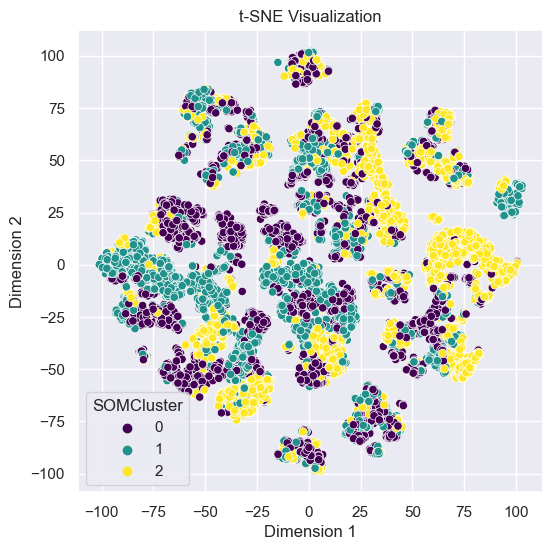

In [28]:
def tsne(data_with_clusters, cluster_column='SOMCluster'):

    features = data_with_clusters.drop(cluster_column, axis=1)
    clusters = data_with_clusters[cluster_column]

    tsne = TSNE(n_components=2, random_state=10)
    tsne_result = tsne.fit_transform(features)

    tsne_df = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
    tsne_df[cluster_column] = clusters

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue=cluster_column, data=tsne_df, palette='viridis', legend='full')
    plt.title(f't-SNE Visualization')
    plt.show()

# Visualize clusters
tsne(data_std3_with_clusters, cluster_column='SOMCluster')

C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


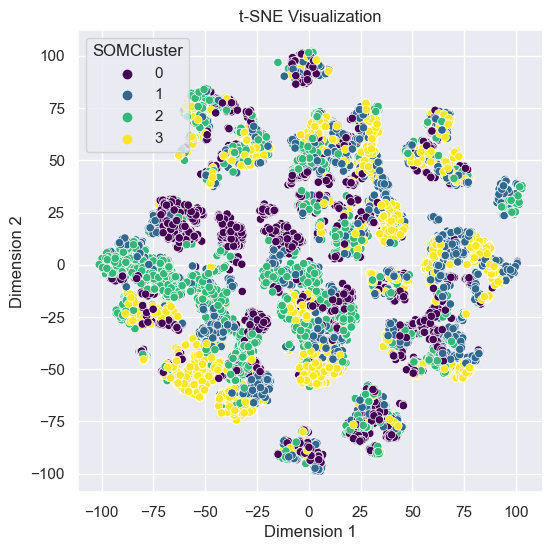

In [29]:
tsne(data_std4_with_clusters, cluster_column='SOMCluster')

# Density Based Clustering

In [30]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss      

In [31]:
matrix_list = [data_std, data_mm]
titles = ["Standard Scaler", "MinMax Scaler"]

### Mean Shift Clustering 
Iteratively shifts data points towards the peak of the local density.

In [32]:
def train_meanshift_cluster(data, metric_features, bandwidth):
    
    np.random.seed(10)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    
    # Fit and predict clusters on the metric features
    ms_labels = ms.fit_predict(data[metric_features])
    data_with_clusters = data.copy()
    data_with_clusters['ClusterLabels'] = ms_labels

    # Get R^2
    sst = get_ss(data_with_clusters[metric_features])  
    ssw_labels = data_with_clusters.groupby(by='ClusterLabels').apply(lambda x: get_ss(x[metric_features]))
    ssb = sst - ssw_labels.sum()
    r2 = ssb / sst
    print(f"Cluster solution R^2 for MeanShift: {r2:.4f}")

    cluster_means = data_with_clusters.groupby('ClusterLabels').mean().T
    styled_cluster_means = cluster_means.style.format(precision=2).background_gradient(axis=1)

    return data_with_clusters, styled_cluster_means

In [33]:
# Adjust Bandwidth to get different number of clusters (will impact R^2)
data_std_with_clusters, styled_cluster_std = train_meanshift_cluster(data_std, metric_features, bandwidth=5.0)
data_mm_with_clusters, styled_cluster_mm = train_meanshift_cluster(data_mm, metric_features, bandwidth=0.5)

Cluster solution R^2 for MeanShift: 0.1273
Cluster solution R^2 for MeanShift: 0.1102


In [34]:
styled_cluster_mm     

ClusterLabels,0,1,2,3
Gender,0.40,0.36,0.43,0.49
Income,0.25,0.09,0.16,0.13
DaysWithoutFrequency,0.16,0.64,0.21,0.04
LifetimeValue,0.11,0.10,0.57,0.60
UseByTime,0.05,0.00,0.03,0.03
WaterActivities,0.28,0.50,0.86,0.83
FitnessActivities,0.59,0.17,0.23,0.15
TeamActivities,0.05,0.15,0.14,0.06
RacketActivities,0.02,0.11,0.03,0.02
CombatActivities,0.11,0.11,0.00,0.06


### Gaussian Mixture Model 
Provides a probability of each observation belonging to each cluster.

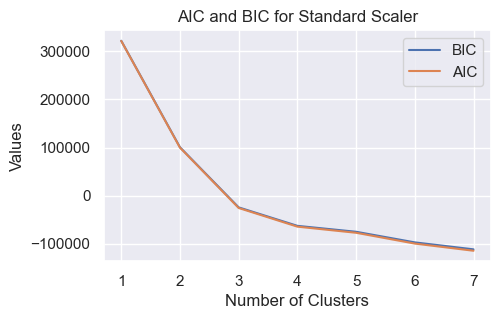

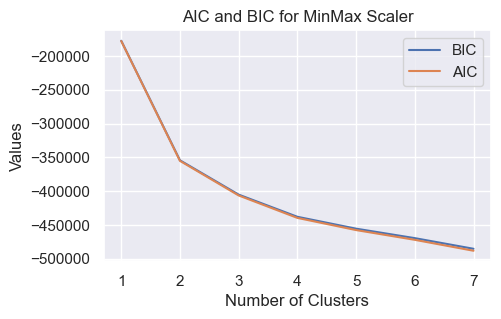

In [35]:
# To choose number of clusters (elbow method)

n_components = np.arange(1, 8)
for title, matrix in zip(titles, matrix_list):

    matrix_metric = matrix[metric_features]
    
    # Fit GMM models 
    models = [GaussianMixture(n, covariance_type='full', n_init=20, random_state=10).fit(matrix_metric)
              for n in n_components]

    bic_values = [m.bic(matrix_metric) for m in models]
    aic_values = [m.aic(matrix_metric) for m in models]

    plt.figure(figsize=(5, 3))
    plt.plot(n_components, bic_values, label='BIC')
    plt.plot(n_components, aic_values, label='AIC')
    plt.legend(loc='best')
    plt.title(f"AIC and BIC for {title}")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Values')
    plt.xticks(n_components)
    plt.show()  

# MinMax has lower values -> likely better

In [36]:
def train_gmm_cluster(data, metric_features, n_components):
    
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=20, init_params='k-means++', random_state=10)
    gmm_labels = gmm.fit_predict(data[metric_features])

    data_with_clusters = data.copy()
    data_with_clusters['ClusterLabels'] = gmm_labels

    # Get R^2 
    sst = get_ss(data_with_clusters[metric_features])
    ssw_labels = data_with_clusters.groupby(by='ClusterLabels').apply(lambda x: get_ss(x[metric_features]))
    ssb = sst - ssw_labels.sum()
    r2 = ssb / sst
    print(f"Cluster solution R^2 for GMM: {r2:.4f}")

    cluster_means = data_with_clusters.groupby('ClusterLabels').mean().T
    styled_cluster_means = cluster_means.style.format(precision=2).background_gradient(axis=1)

    return data_with_clusters, styled_cluster_means

# from elbow method
num_components_std = 4  
num_components_mm = 3   

data_std_with_clusters_gmm, styled_cluster_std_gmm = train_gmm_cluster(data_std, metric_features, n_components=num_components_std)
data_mm_with_clusters_gmm, styled_cluster_mm_gmm = train_gmm_cluster(data_mm, metric_features, n_components=num_components_mm)

Cluster solution R^2 for GMM: 0.1998
Cluster solution R^2 for GMM: 0.1602


In [37]:
styled_cluster_std_gmm     

ClusterLabels,0,1,2,3
Gender,0.09,0.00,0.11,-0.10
Income,0.27,-0.45,-0.05,0.08
DaysWithoutFrequency,-0.08,-0.08,-0.07,0.15
LifetimeValue,0.11,0.51,1.54,-0.63
UseByTime,0.23,-0.15,0.20,-0.13
WaterActivities,-0.25,0.75,0.67,-0.38
FitnessActivities,0.28,-0.86,-0.23,0.39
TeamActivities,-0.14,0.43,0.11,-0.19
RacketActivities,-0.14,0.38,0.09,-0.15
CombatActivities,0.17,-0.23,-0.11,0.02


C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\DOCUMENTOS\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


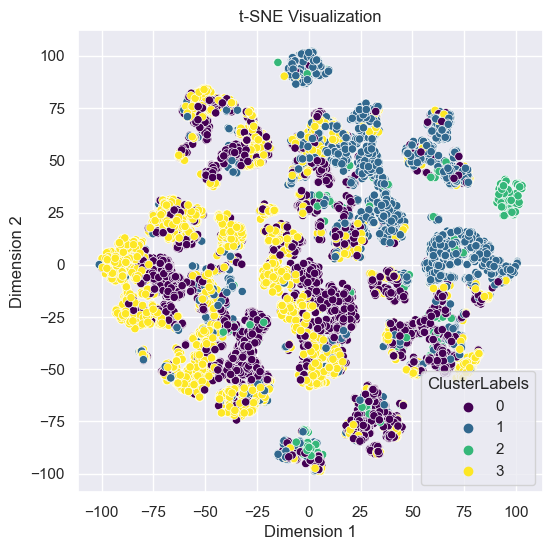

In [38]:
tsne(data_std_with_clusters_gmm, cluster_column='ClusterLabels')

# Clustering by Perspectives

In [39]:
data_std_dem = data_std[demographic_features]
data_std_beh = data_std[behaviou_features]
data_std_act = data_std[activities_features]
data_std_sub = data_std[subscription_features]

data_mm_dem = data_mm[demographic_features]
data_mm_beh = data_mm[behaviou_features]
data_mm_act = data_mm[activities_features]
data_mm_sub = data_mm[subscription_features]

### Optimal clusterer for each variable

In [40]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset."""
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10, model_name='kmeans'):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    if model_name in ['dbscan', 'meanshift']:
        clust = clone(clusterer)
        labels = clust.fit_predict(df)
        r2_clust['default'] = r2(df, labels)
    elif model_name == 'gmm':
        for n in range(min_k, max_k):
            clust = clone(clusterer).set_params(n_components=n)
            clust.fit(df)
            labels = clust.predict(df)
            r2_clust[n] = r2(df, labels)
    else:  # kmeans, hierarchical
        for n in range(min_k, max_k):
            clust = clone(clusterer).set_params(n_clusters=n)
            labels = clust.fit_predict(df)
            r2_clust[n] = r2(df, labels)
    return r2_clust




In [41]:
# Clusterers setup
kmeans = KMeans(init='k-means++', n_init=20, random_state=10)
hierarchical = AgglomerativeClustering(metric='euclidean')
gmm = GaussianMixture(n_components=2, covariance_type='full', n_init=20, init_params='k-means++', random_state=10)

In [42]:
dataframes = {'Demographic': data_mm_dem, 'Behaviour': data_mm_beh, 'Activities': data_mm_act, 'Subscription': data_mm_sub}

In [43]:
models = {'kmeans': kmeans, 'gmm': gmm} # hierarchical added later

# R² scores
r2_scores = {}
for df_name, df in dataframes.items():
    r2_scores[df_name] = {}
    for model_name, model in models.items():
        r2_scores[df_name][model_name] = get_r2_scores(df, model, model_name=model_name)

    # Hierarchical with different linkages
    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[df_name][linkage] = get_r2_scores(
            df, hierarchical.set_params(linkage=linkage), model_name='hierarchical'
        )

for df_name, scores in r2_scores.items():
    print(f"R² scores for {df_name}:")
    display(pd.DataFrame(scores))

R² scores for Demographic:


,kmeans,gmm,complete,average,single,ward
2,0.830860,0.830860,0.830860,0.830860,0.830860,0.830860
3,0.870085,0.849354,0.861366,0.831266,0.831217,0.863869
4,0.895922,0.880611,0.876764,0.846339,0.831623,0.886607
5,0.917377,0.901939,0.895608,0.861497,0.831815,0.907423
6,0.935899,0.915554,0.910173,0.878399,0.831963,0.926597
7,0.945266,0.920026,0.913724,0.914139,0.831965,0.936793
8,0.952967,0.922503,0.914830,0.914653,0.832101,0.945404
9,0.958073,0.932113,0.917301,0.917452,0.832169,0.953022


R² scores for Behaviour:


,kmeans,gmm,complete,average,single,ward
2,0.354209,0.130571,0.207003,0.000718,0.207003,0.302261
3,0.546401,0.209473,0.524727,0.207722,0.207269,0.509070
4,0.637079,0.252741,0.527414,0.210868,0.207988,0.608751
5,0.696116,0.418767,0.573022,0.247976,0.208262,0.658465
6,0.730572,0.514671,0.655790,0.357273,0.208524,0.706213
7,0.757557,0.516503,0.670404,0.358021,0.208793,0.729930
8,0.781360,0.515368,0.672754,0.383672,0.209329,0.752094
9,0.797597,0.542329,0.701557,0.384574,0.209741,0.767160


R² scores for Activities:


,kmeans,gmm,complete,average,single,ward
2,0.517463,0.172591,0.078345,0.001470,0.000236,0.460177
3,0.719940,0.549364,0.557659,0.003346,0.000892,0.679719
4,0.808143,0.768143,0.608834,0.003740,0.002214,0.785811
5,0.850057,0.812610,0.619664,0.100341,0.002490,0.841865
6,0.891305,0.877224,0.828473,0.275861,0.002772,0.878541
7,0.917593,0.904632,0.831012,0.771556,0.003310,0.911732
8,0.940103,0.940100,0.840551,0.847950,0.004034,0.936126
9,0.947525,0.951326,0.848472,0.868639,0.004531,0.946703


R² scores for Subscription:


,kmeans,gmm,complete,average,single,ward
2,0.790673,0.790673,0.790673,0.790673,0.790673,0.790673
3,0.889841,0.885096,0.879483,0.826374,0.804076,0.886130
4,0.942285,0.899380,0.928814,0.916899,0.839777,0.937244
5,0.961774,0.949325,0.941556,0.942521,0.840017,0.958808
6,0.971627,0.955907,0.945692,0.946670,0.840028,0.969184
7,0.981161,0.974032,0.973559,0.974375,0.840272,0.976614
8,0.985422,0.980861,0.975575,0.977921,0.840327,0.983958
9,0.988987,0.982843,0.978721,0.979860,0.855413,0.987316


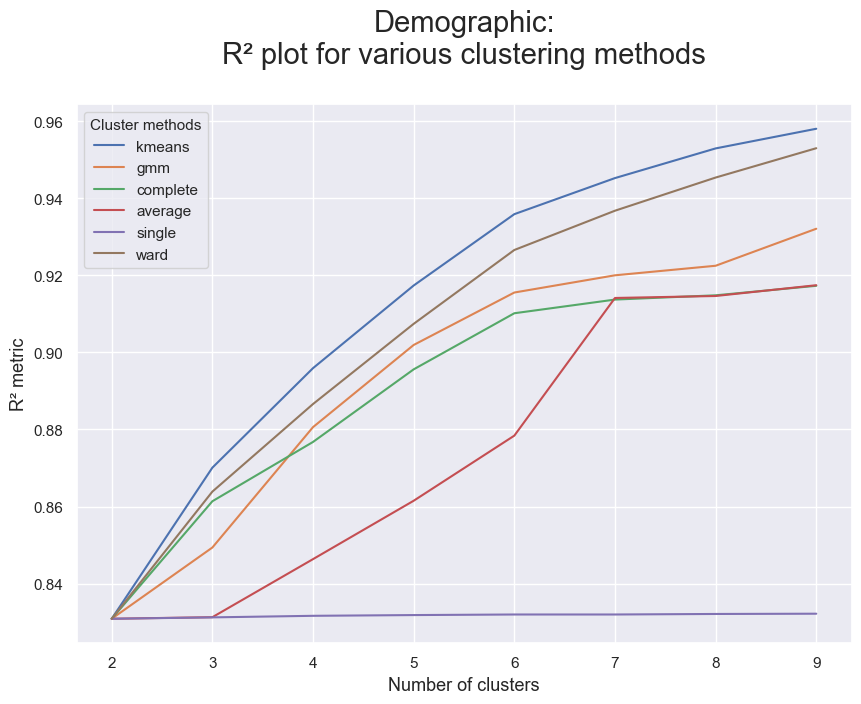

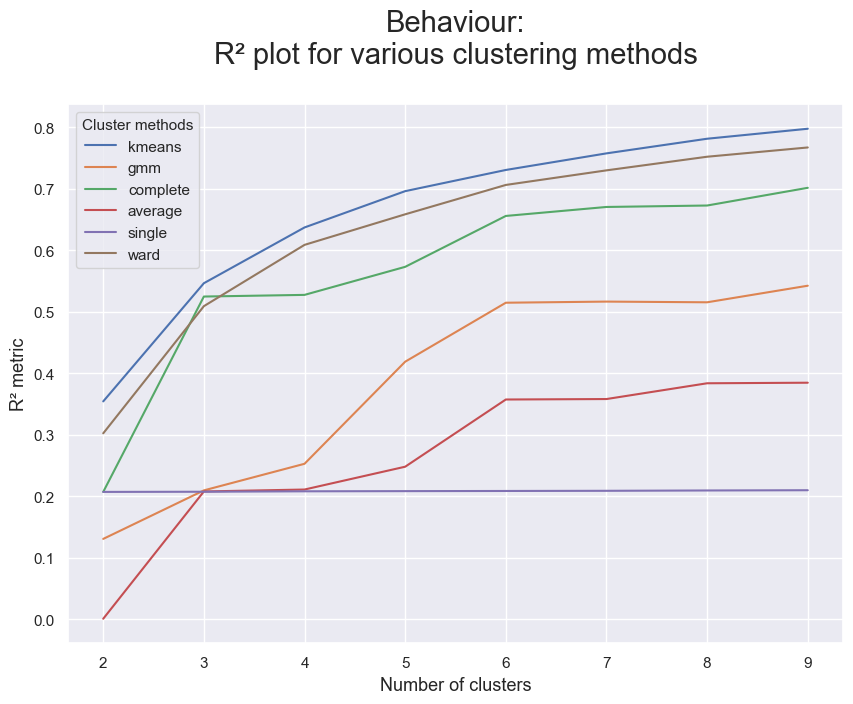

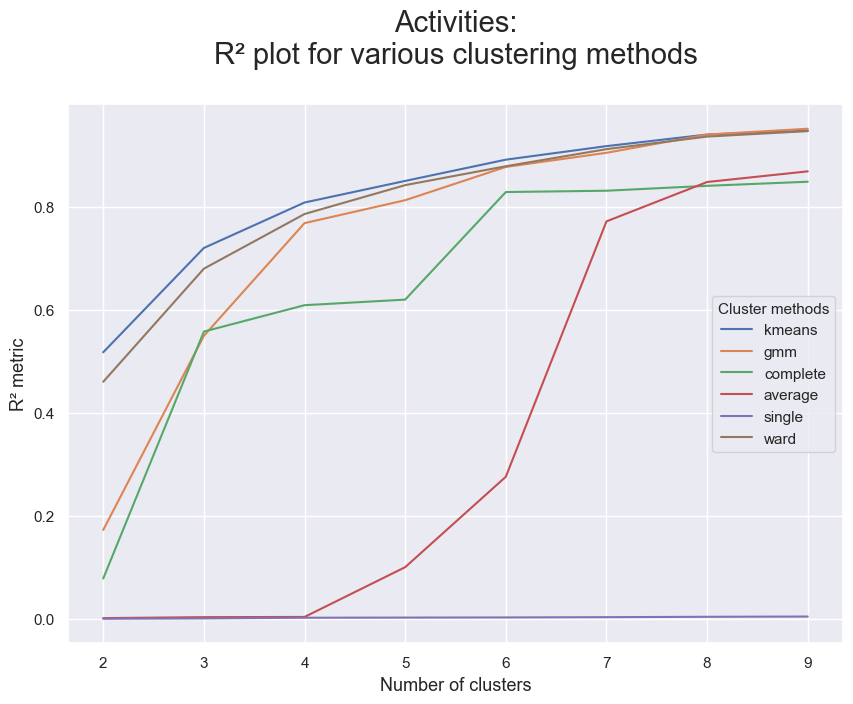

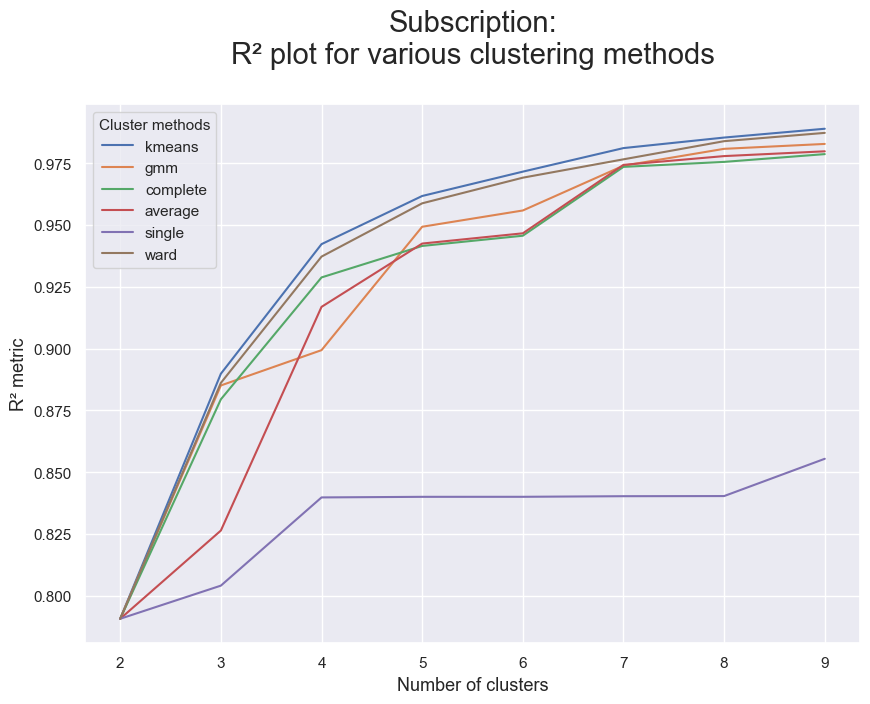

In [44]:
# Plot r2 scores for each method
def plot_r2_scores(scores, df_name):
    plt.figure(figsize=(10, 7))

    cluster_range = range(2, 10)  

    for method, r2 in scores.items():
        if isinstance(r2, dict):  # For methods with varying cluster numbers
            plt.plot(list(r2.keys()), list(r2.values()), label=method)
        else:  
            plt.axhline(y=r2, label=method, linestyle='--') # would only apply if r2 score doesn't change with number of clusters

    plt.title(f"{df_name}:\nR² plot for various clustering methods\n", fontsize=21)
    plt.legend(title="Cluster methods", title_fontsize=11)
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R² metric", fontsize=13)

    plt.xticks(cluster_range)

    plt.show()

for df_name, scores in r2_scores.items():
    plot_r2_scores(scores, df_name)


### Seperate for DBScan and MeanShift

In [45]:
# check r2 dependent on bandwidth
def get_r2_scores_meanshift(df, bandwidth_range):
    r2_scores = {}
    for bandwidth in bandwidth_range:
        meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels = meanshift.fit_predict(df)
        r2_scores[bandwidth] = r2(df, labels)
    return r2_scores

#check r2 dependent on eps and min_samples
def get_r2_scores_dbscan(df, eps_range, min_samples_range):
    r2_scores = {}
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
            labels = dbscan.fit_predict(df)
            param_key = f"eps={eps}, min_samples={min_samples}"
            r2_scores[param_key] = r2(df, labels)
    return r2_scores

# Define ranges for parameters
bandwidth_range = np.linspace(0.1, 2, num=10)  
eps_range = np.linspace(0.1, 2, num=10)        
min_samples_range = range(2, 10)               

# for each perspective
perspectives = {'DemographicMM': data_mm_dem, 'ActivityMM': data_mm_act, 'BehaviourMM': data_mm_beh, 'SubscriptionMM': data_mm_sub}

# Get r2 scores 
r2_scores_perspective = {}
for perspective_name, df in perspectives.items():
    r2_scores_perspective[perspective_name] = {
        'MeanShift': get_r2_scores_meanshift(df, bandwidth_range),
        'DBSCAN': get_r2_scores_dbscan(df, eps_range, min_samples_range)
    }


for perspective_name, scores in r2_scores_perspective.items():
    print(f"R² scores for {perspective_name}:")
    for method, r2_scores in scores.items():
        print(f"  {method}:")
        for params, score in r2_scores.items():
            print(f"    {params}: {score}")

R² scores for DemographicMM:
  MeanShift:
    0.1: 0.9486216344856758
    0.3111111111111111: 0.8308595522983256
    0.5222222222222223: 0.8308595522983256
    0.7333333333333333: 0.8308595522983256
    0.9444444444444444: 0.8308595522983256
    1.1555555555555557: 0.0
    1.3666666666666667: 0.0
    1.577777777777778: 0.0
    1.788888888888889: 0.0
    2.0: 0.0
  DBSCAN:
    eps=0.1, min_samples=2: 0.8316925215869329
    eps=0.1, min_samples=3: 0.8315374095861345
    eps=0.1, min_samples=4: 0.8316067159725651
    eps=0.1, min_samples=5: 0.8317197538038705
    eps=0.1, min_samples=6: 0.8317601194928529
    eps=0.1, min_samples=7: 0.8320098320868295
    eps=0.1, min_samples=8: 0.832107937073179
    eps=0.1, min_samples=9: 0.8321427596739823
    eps=0.3111111111111111, min_samples=2: 0.8308595522983256
    eps=0.3111111111111111, min_samples=3: 0.8308595522983256
    eps=0.3111111111111111, min_samples=4: 0.8308595522983256
    eps=0.3111111111111111, min_samples=5: 0.8308595522983256
  

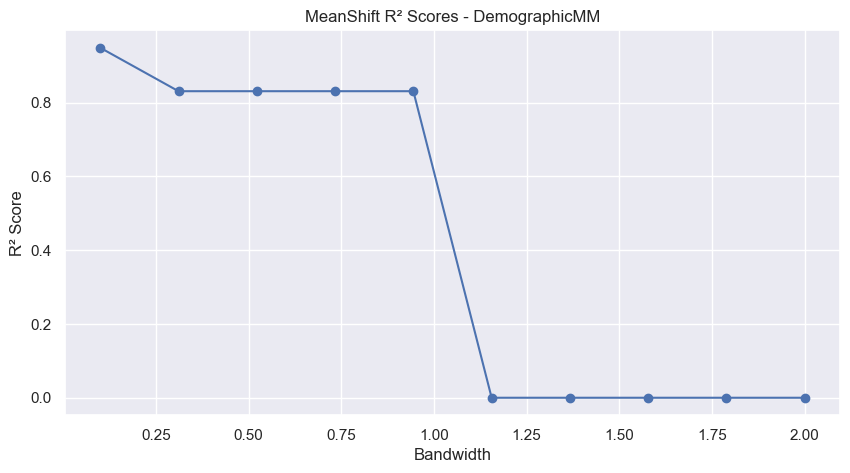

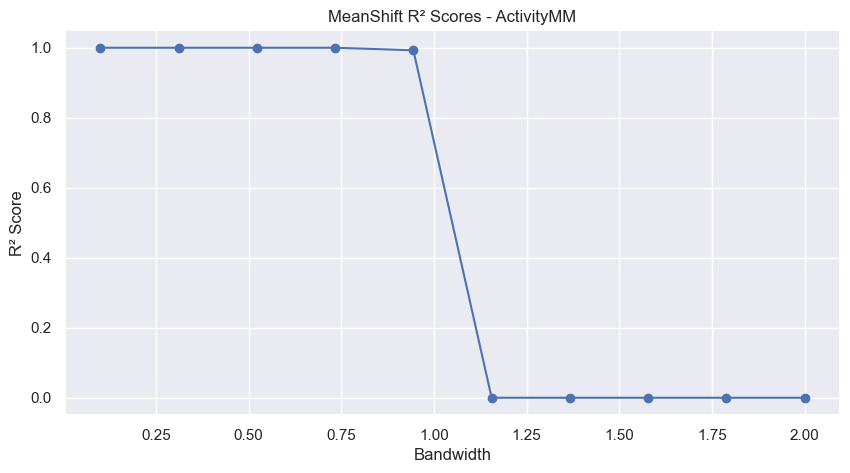

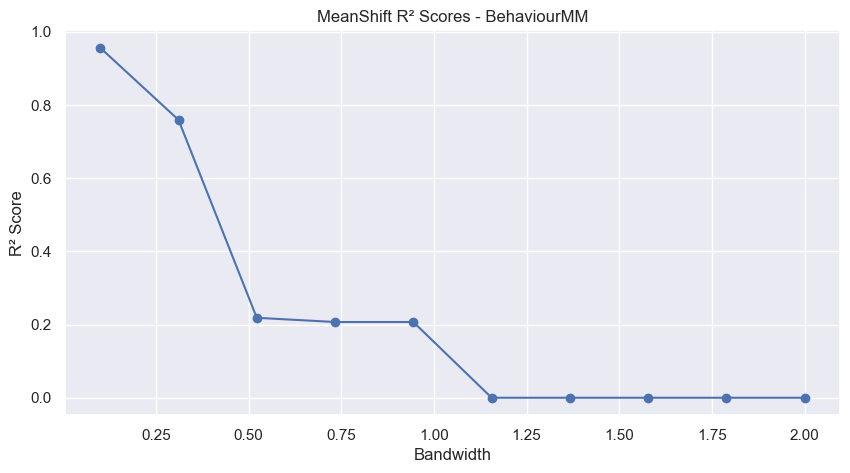

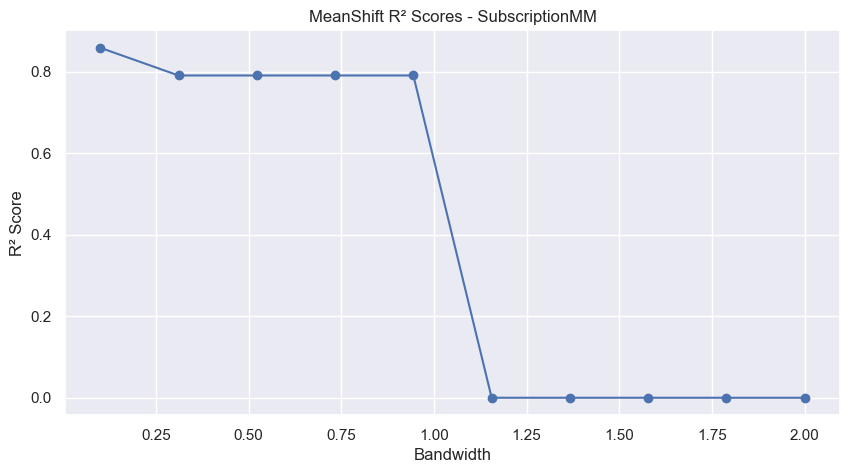

In [46]:
def plot_meanshift_r2_scores(r2_scores, title):
    plt.figure(figsize=(10, 5))
    plt.plot(r2_scores.keys(), r2_scores.values(), marker='o')
    plt.title(title)
    plt.xlabel('Bandwidth')
    plt.ylabel('R² Score')
    plt.grid(True)
    plt.show()

# Plotting r2 scores for bandwidth for each perspective
for perspective_name, scores in r2_scores_perspective.items():
    plot_meanshift_r2_scores(scores['MeanShift'], f"MeanShift R² Scores - {perspective_name}")


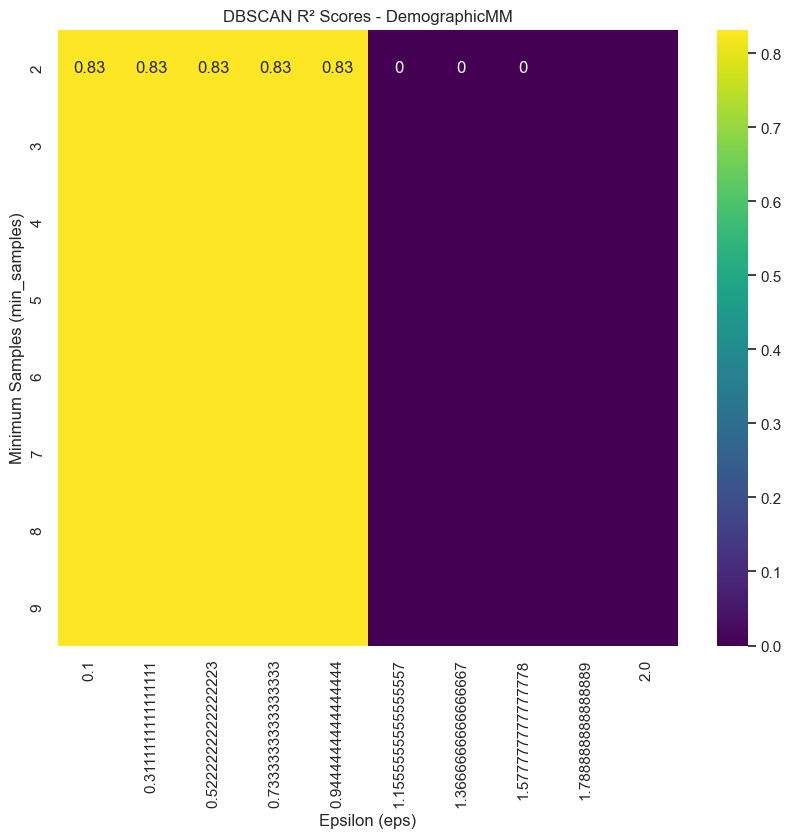

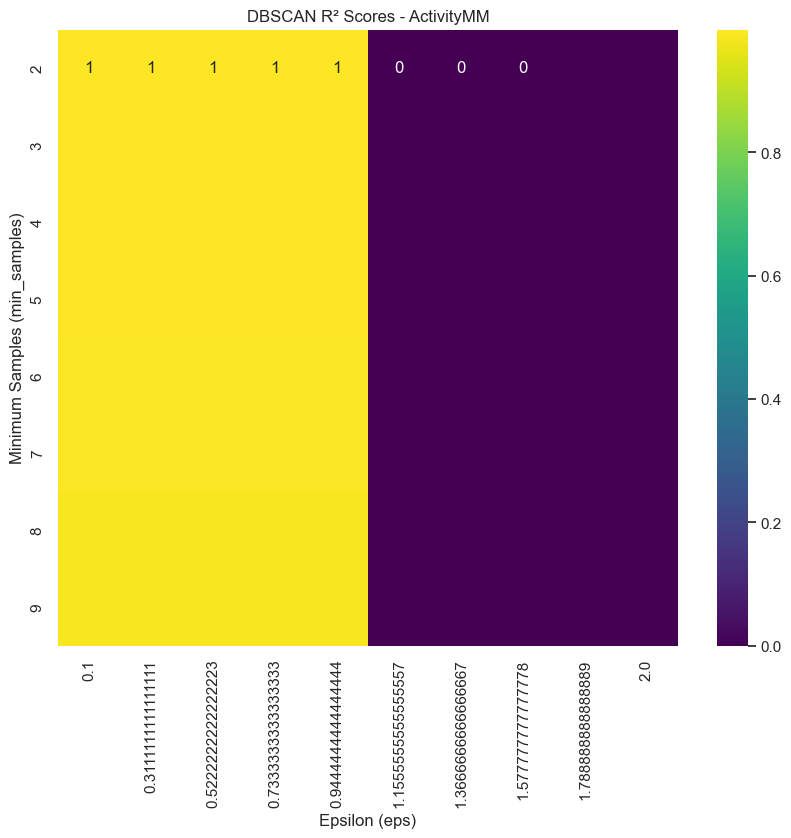

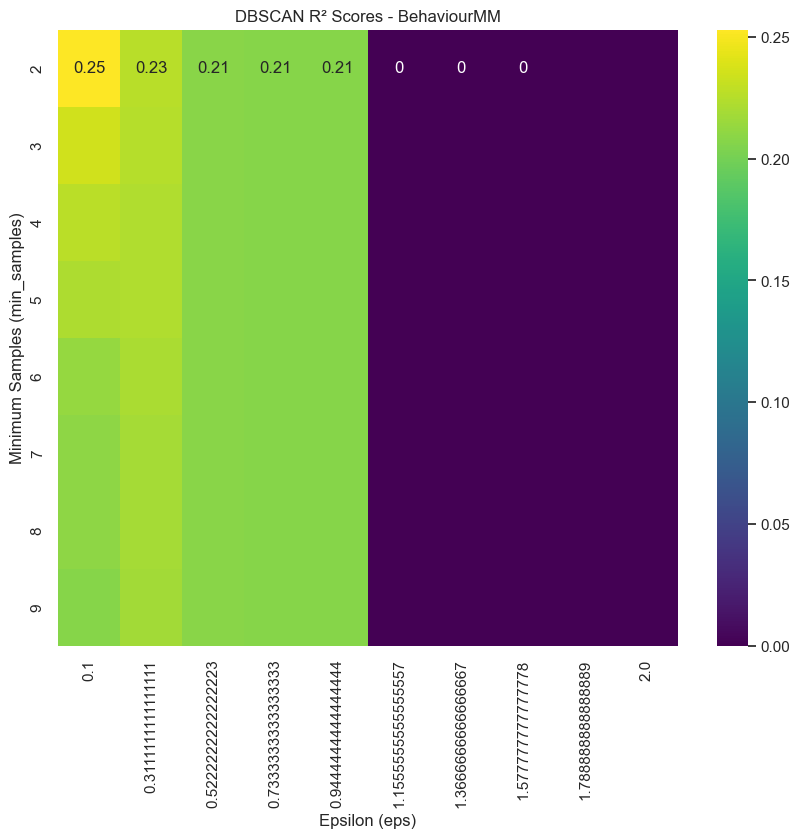

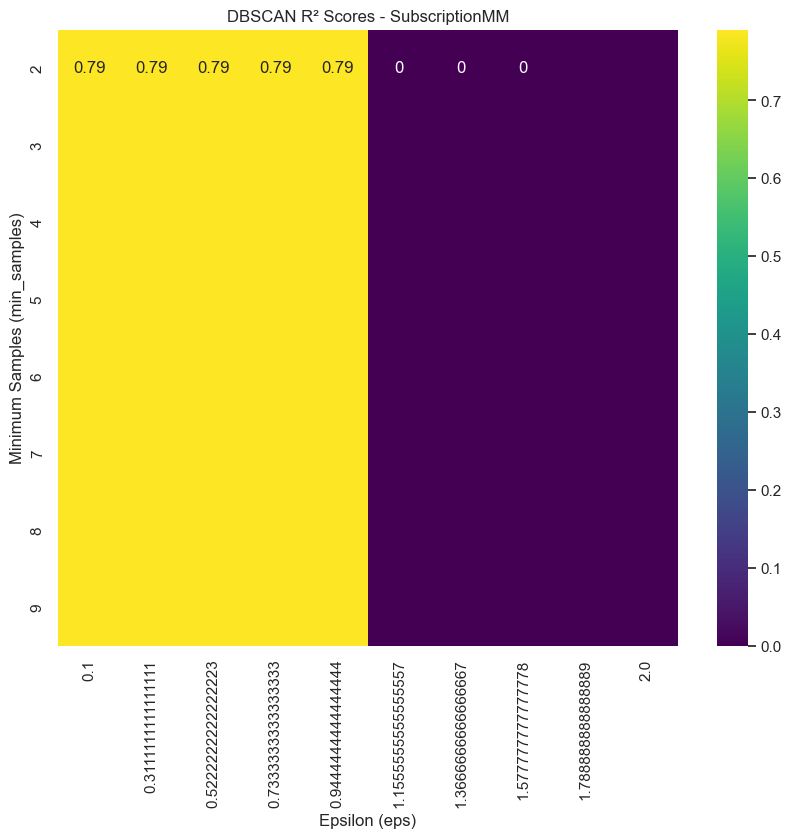

In [47]:
def plot_dbscan_r2_scores(r2_scores, eps_range, min_samples_range, title):
  
    heatmap_data = pd.DataFrame(index=min_samples_range, columns=eps_range, dtype=float)
    for params, score in r2_scores.items():
        eps, min_samples = map(float, params.replace('eps=', '').replace('min_samples=', '').split(', '))
        heatmap_data.at[min_samples, eps] = score

    heatmap_data = heatmap_data.astype(float)

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis')
    plt.title(title)
    plt.xlabel('Epsilon (eps)')
    plt.ylabel('Minimum Samples (min_samples)')
    plt.show()

# Plotting r2 scores for DBSCAN for each perspective depending on eps and min_samples
for perspective_name, scores in r2_scores_perspective.items():
    plot_dbscan_r2_scores(scores['DBSCAN'], eps_range, min_samples_range, f"DBSCAN R² Scores - {perspective_name}")

In [2]:
# Based on the above plots, we choose KMeans for clustering
# - 3 clusters for demographic features
# - 3 clusters for behaviour features
# - 3 clusters for activity features
# - 3 clusters for subscription features

## Merging Perspectives

In [49]:
num_clusters = 3

kmeans_dem = KMeans(n_clusters=num_clusters, init='k-means++', n_init=20, random_state=10)
demographic_labels = kmeans_dem.fit_predict(data_mm_dem)

kmeans_beh = KMeans(n_clusters=num_clusters, init='k-means++', n_init=20, random_state=10)
behavior_labels = kmeans_beh.fit_predict(data_mm_beh)

kmeans_act = KMeans(n_clusters=num_clusters, init='k-means++', n_init=20, random_state=10)
activities_labels = kmeans_act.fit_predict(data_mm_act)

kmeans_sub = KMeans(n_clusters=num_clusters, init='k-means++', n_init=20, random_state=10)
subscription_labels = kmeans_sub.fit_predict(data_mm_sub)

# Assign labels to the original data
data_mm['Demographic_labels'] = demographic_labels
data_mm['Behaviour_labels'] = behavior_labels
data_mm['Activities_labels'] = activities_labels
data_mm['Subscription_labels'] = subscription_labels

In [50]:
pd.crosstab(data_mm['Demographic_labels'], data_mm['Behaviour_labels'])

Behaviour_labels,0,1,2
Demographic_labels,,,
0,3197,3389,269
1,2406,3004,324
2,701,953,83


In [51]:
data_mm.groupby(['Demographic_labels', 'Behaviour_labels'])[demographic_features + behaviou_features].mean()

Gender    Income  LifetimeValue  \
Demographic_labels Behaviour_labels                                    
0                  0                    0.0  0.190690       0.072381   
                   1                    0.0  0.161282       0.135004   
                   2                    0.0  0.225420       0.119184   
1                  0                    1.0  0.235021       0.084386   
                   1                    1.0  0.226900       0.177154   
                   2                    1.0  0.321067       0.164125   
2                  0                    0.0  0.509805       0.106286   
                   1                    0.0  0.527515       0.162149   
                   2                    0.0  0.480599       0.174149   

                                     DaysWithoutFrequency  UseByTime  \
Demographic_labels Behaviour_labels                                    
0                  0                             0.241850        0.0   
                   1                             0.093732        0.0   
                   2                             0.258159        1.0   
1                  0                             0.213646        0.0   
                   1                             0.091463        0.0   
                   2                             0.254110        1.0   
2                  0                             0.253192        0.0   
                   1                             0.104679        0.0   
                   2                             0.225616        1.0   

                                     NumberOfFrequencies  AttendedClasses  \
Demographic_labels Behaviour_labels                                         
0                  0                            0.050410         0.019003   
                   1                            0.093047         0.069718   
                   2                            0.136251         0.017752   
1                  0                            0.060621         0.022515   
                   1                            0.140482         0.076413   
                   2                            0.167304         0.014046   
2                  0                            0.061739         0.033863   
                   1                            0.146305         0.059345   
                   2                            0.163474         0.026674   

                                     NumberOfReferences  DaysSinceLastVisit  \
Demographic_labels Behaviour_labels                                           
0                  0                           0.007716            0.685633   
                   1                           0.005508            0.140076   
                   2                           0.001239            0.310441   
1                  0                           0.008035            0.659901   
                   1                           0.006103            0.132155   
                   2                           0.005144            0.301353   
2                  0                           0.008559            0.673877   
                   1                           0.003498            0.128961   
                   2                           0.008032            0.311996   

                                     LazinessIndex  
Demographic_labels Behaviour_labels                 
0                  0                      0.923090  
                   1                      0.891414  
                   2                      0.900745  
1                  0                      0.921278  
                   1                      0.879638  
                   2                      0.896809  
2                  0                      0.933698  
                   1                      0.893160  
                   2                      0.906269

In [52]:
pd.crosstab(data_mm['Demographic_labels'], data_mm['Activities_labels'])

Activities_labels,0,1,2
Demographic_labels,,,
0,1990,3990,875
1,1671,2833,1230
2,497,1060,180


In [53]:
data_mm.groupby(['Demographic_labels', 'Activities_labels'])[demographic_features + activities_features].mean()

Gender    Income  LifetimeValue  \
Demographic_labels Activities_labels                                    
0                  0                     0.0  0.110500       0.189111   
                   1                     0.0  0.215905       0.062729   
                   2                     0.0  0.154858       0.107851   
1                  0                     1.0  0.175094       0.217740   
                   1                     1.0  0.270962       0.088432   
                   2                     1.0  0.236487       0.141470   
2                  0                     0.0  0.503650       0.194408   
                   1                     0.0  0.527737       0.115315   
                   2                     0.0  0.501497       0.136853   

                                      WaterActivities  FitnessActivities  \
Demographic_labels Activities_labels                                       
0                  0                         1.000000           0.079899   
                   1                         0.000000           1.000000   
                   2                         0.001143           0.004571   
1                  0                         1.000000           0.080790   
                   1                         0.000000           1.000000   
                   2                         0.004878           0.004065   
2                  0                         1.000000           0.283702   
                   1                         0.000000           1.000000   
                   2                         0.000000           0.000000   

                                      TeamActivities  RacketActivities  \
Demographic_labels Activities_labels                                     
0                  0                        0.016080          0.004523   
                   1                        0.002256          0.003509   
                   2                        0.286857          0.142857   
1                  0                        0.039497          0.002992   
                   1                        0.009884          0.004236   
                   2                        0.277236          0.112195   
2                  0                        0.004024          0.006036   
                   1                        0.002830          0.005660   
                   2                        0.088889          0.111111   

                                      CombatActivities  SpecialActivities  
Demographic_labels Activities_labels                                       
0                  0                          0.020101           0.005528  
                   1                          0.024812           0.008020  
                   2                          0.515429           0.027429  
1                  0                          0.034111           0.011969  
                   1                          0.063184           0.019061  
                   2                          0.519512           0.080488  
2                  0                          0.010060           0.038229  
                   1                          0.015094           0.022642  
                   2                          0.316667           0.400000

In [54]:
pd.crosstab(data_mm['Demographic_labels'], data_mm['Subscription_labels'])

Subscription_labels,0,1,2
Demographic_labels,,,
0,4878,1161,816
1,3649,1153,932
2,1097,368,272


In [55]:
data_mm.groupby(['Demographic_labels', 'Subscription_labels'])[demographic_features + subscription_features].mean()

Gender    Income  LifetimeValue  \
Demographic_labels Subscription_labels                                    
0                  0                       0.0  0.191532       0.063194   
                   1                       0.0  0.125037       0.186058   
                   2                       0.0  0.168377       0.241075   
1                  0                       1.0  0.239415       0.074707   
                   1                       1.0  0.218350       0.237276   
                   2                       1.0  0.242180       0.259867   
2                  0                       0.0  0.508868       0.082183   
                   1                       0.0  0.555365       0.201020   
                   2                       0.0  0.505085       0.291758   

                                        EnrolledTime  Dropout  
Demographic_labels Subscription_labels                         
0                  0                        0.109434      1.0  
                   1                        0.272167      0.0  
                   2                        0.512084      1.0  
1                  0                        0.114496      1.0  
                   1                        0.347913      0.0  
                   2                        0.523645      1.0  
2                  0                        0.118081      1.0  
                   1                        0.319555      0.0  
                   2                        0.533625      1.0

### Getting the clusters 

In [56]:
kmeans_demo_beh = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=10)

# Select the relevant features for clustering
selected_features = data_mm[demographic_features + behaviou_features]

# Fit the KMeans model 
cluster_labels_demo_beh = kmeans_demo_beh.fit_predict(selected_features)
data_mm['Cluster_labels_demo_beh'] = cluster_labels_demo_beh

In [57]:
data_mm.groupby('Cluster_labels_demo_beh')[demographic_features + behaviou_features].mean()

,Gender,Income,LifetimeValue,DaysWithoutFrequency,UseByTime,NumberOfFrequencies,AttendedClasses,NumberOfReferences,DaysSinceLastVisit,LazinessIndex
Cluster_labels_demo_beh,,,,,,,,,,
0,1.0,0.235629,0.137492,0.151922,0.056505,0.108488,0.050273,0.006860,0.363159,0.898081
1,0.0,0.246374,0.112253,0.169492,0.040968,0.082568,0.044729,0.006246,0.392386,0.907279


In [58]:
kmeans_demo_act = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=10)

# Select the relevant features for clustering
selected_features = data_mm[demographic_features + activities_features]

# Fit the KMeans model 
cluster_labels_demo_act = kmeans_demo_act.fit_predict(selected_features)
data_mm['Cluster_labels_demo_act'] = cluster_labels_demo_act

In [59]:
data_mm.groupby('Cluster_labels_demo_act')[demographic_features + activities_features].mean()

,Gender,Income,LifetimeValue,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities
Cluster_labels_demo_act,,,,,,,,,
0,0.413358,0.164051,0.198961,1.000000,0.000000,0.026019,0.003487,0.021459,0.005097
1,0.000000,0.273852,0.086814,0.046995,0.835909,0.043872,0.026073,0.098985,0.026386
2,1.000000,0.262899,0.108535,0.032435,0.709039,0.088242,0.036251,0.197710,0.039828


In [60]:
kmeans_demo_sub = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=10)

# Select the relevant features for clustering
selected_features = data_mm[demographic_features + subscription_features]

# Fit the KMeans model 
cluster_labels_demo_sub = kmeans_demo_sub.fit_predict(selected_features)
data_mm['Cluster_labels_demo_sub'] = cluster_labels_demo_sub

In [61]:
data_mm.groupby('Cluster_labels_demo_sub')[demographic_features + subscription_features].mean()

,Gender,Income,LifetimeValue,EnrolledTime,Dropout
Cluster_labels_demo_sub,,,,,
0,1.0,0.235629,0.137492,0.227935,0.798919
1,0.0,0.246374,0.112253,0.193196,0.822044
